# 医薬情報テキストマイニングチャレンジ

* [コンテスト詳細 ビッグデータ活用ならオプトDSL DeepAnalytics](https://deepanalytics.jp/compe/38/)

## Preprocess

In [1]:
import numpy as np
import pandas as pd
from IPython.display import FileLink

In [2]:
data = pd.read_table('data/train.tsv')
test = pd.read_table('data/test.tsv', header=None)
num = len(data)
test_num = len(test)

In [3]:
data.head(10)

,before,after
0,便塊除去,摘便
1,アルツハイマ-認知症,アルツハイマー型認知症
2,熱傷（背部）,背部熱傷、程度不明（部位を限定しない）
3,2015.8.12骨盤-その他-前立腺癌,前立腺癌
4,口のにがみ,苦味
5,軽度呼吸困難感,呼吸困難
6,両足関節偽痛風,偽痛風
7,内痔核出血,痔出血
8,背部皮脂欠乏性湿疹,皮脂欠乏性湿疹
9,左側頭葉出血,脳出血


In [4]:
len(data['after'].drop_duplicates())

4217

## Mecab をインストールする

まずは、MeCabをインストール。

       sudo apt-get install mecab mecab-naist-jdic mecab-ipadic-utf8 libmecab-dev
       pip install mecab-python3

Mecabには、医療辞書を使う(ComJisyo) 
[リリース ComeJisyo Linux用システム辞書 \- ComeJisyo \- OSDN](https://ja.osdn.net/projects/comedic/releases/44305)

インストールでは、utf-8でインストールすることが必要。

    ./configure --with-charset-=utf8　

* [MeCabをUTF-8でインストールしたい。 - Qiita](http://qiita.com/junpooooow/items/0a7d13addc0acad10606)

In [5]:
import MeCab
#m = MeCab.Tagger("-Owakati")
m = MeCab.Tagger("-Ochasen")
#data['before'] = data['before'].apply(m.parseToNode)
#test1 = test[0].apply(m.parseToNode)

In [6]:
node = m.parseToNode("足がふらつく")
while node:
    print(node.feature)
    node = node.next

BOS/EOS,*,*,*,*,*,*,*,*
名詞,一般,*,*,*,*,足,アシ,アシ
助詞,格助詞,一般,*,*,*,が,ガ,ガ
動詞,自立,*,*,五段・カ行イ音便,基本形,ふらつく,フラツク,フラツク
BOS/EOS,*,*,*,*,*,*,*,*


In [7]:
befores = set()
afters = set()
for i, row in data.iterrows():
    node = m.parseToNode(row[0])
    while node:
        if node.feature.startswith('名詞'):
            befores.add(node.surface)
        if node.feature.startswith('形容詞'):
            befores.add(node.surface)
        if node.feature.startswith('動詞'):
            befores.add(node.surface)
        node = node.next
    afters.add(row[1])

for i in test[0].iteritems():
    node = m.parseToNode(i[1])
    while node:
        if node.feature.startswith('名詞'):
            befores.add(node.surface)
        if node.feature.startswith('形容詞'):
            befores.add(node.surface)
        if node.feature.startswith('動詞'):
            befores.add(node.surface)
        node = node.next

In [8]:
print(len(befores))
#befores.discard('(')
#befores.discard(')')
#befores.discard('（')
#befores.discard('）')
#befores.discard('[')
#befores.discard(']')
#befores.discard('」')
#befores.discard('「')
#befores.discard('【')
#befores.discard('】')
#befores.discard('『')
#befores.discard('』')

#befores.discard("0")
#befores.discard("1")
#befores.discard('2')
#befores.discard('3')
#befores.discard('4')
#befores.discard('5')
#befores.discard('6')
#befores.discard('7')
#befores.discard('8')
#befores.discard('9')
#befores.discard('2015')
#befores.discard('12')

#befores.discard('↓')
#befores.discard('↑')
#befores.discard('→')
#befores.discard('←')
#befores.discard('〜')
#befores.discard('~')
#befores.discard('.')
#befores.discard(',')
#befores.discard('（＇')
#befores.discard('＞')
#befores.discard('＜')
#befores.discard('>')
#befores.discard('<')
#befores.discard('）(')
#befores.discard('（+)')
#befores.discard('（±）')
#befores.discard('-')
print(len(befores))
vocab_size = len(befores)
out_size = len(afters)

9331
9331


In [9]:
from collections import Counter

def create_lookup_tables(words):
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab
before_to_int, int_to_before = create_lookup_tables(befores)
after_to_int, int_to_after = create_lookup_tables(afters)

In [10]:
lens = data['before'].apply(len)
(lens.max(), lens.min(), lens.mean(), lens.median(), lens.var())

(82, 1, 8.30282208588957, 7.0, 20.92056222497029)

(array([  4.00000000e+00,   1.04000000e+02,   3.53000000e+02,
          1.06500000e+03,   1.59700000e+03,   0.00000000e+00,
          1.88700000e+03,   1.55900000e+03,   1.32000000e+03,
          9.82000000e+02,   0.00000000e+00,   7.35000000e+02,
          6.18000000e+02,   4.51000000e+02,   3.20000000e+02,
          0.00000000e+00,   2.51000000e+02,   1.90000000e+02,
          1.75000000e+02,   1.55000000e+02,   8.40000000e+01,
          0.00000000e+00,   6.30000000e+01,   5.10000000e+01,
          4.10000000e+01,   3.50000000e+01,   0.00000000e+00,
          2.70000000e+01,   2.30000000e+01,   2.10000000e+01,
          2.10000000e+01,   0.00000000e+00,   9.00000000e+00,
          1.10000000e+01,   9.00000000e+00,   7.00000000e+00,
          0.00000000e+00,   1.20000000e+01,   7.00000000e+00,
          2.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
        

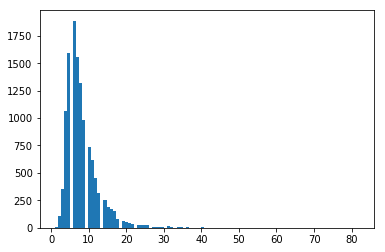

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lens, bins=100)

In [12]:
#seq_len = 20
m2 = MeCab.Tagger("-Owakati")
data['before'] = data['before'].apply(m2.parse)

In [13]:
trainX, trainY= [], []
for i, row in data.iterrows():
    xl = []
    for w in row['before'].split():
#        if len(xl) < seq_len:
        try:
            xl.append(before_to_int[w])
        except KeyError:
            pass
    trainX.append(xl)
    trainY.append(after_to_int[row['after']])

In [14]:
#len(trainX), len(trainY)
trainX[:10], trainY[:10]

([[2481, 3719, 6974],
  [3596, 5099, 7836],
  [6968, 491],
  [2115, 7610, 985, 7610, 8754, 2987, 5099, 5437, 5099, 7738],
  [9030, 2026, 578],
  [8697, 9082, 4933],
  [5980, 2568, 1900],
  [6003, 2510],
  [491, 9052, 6172, 8932, 8128],
  [957, 5196, 2510]],
 [3050, 3138, 117, 1296, 867, 3715, 3426, 1222, 2473, 922])

In [15]:
test1 = test[0].apply(m2.parse)

In [16]:
testX = []

for i, row in test1.iteritems():
    xl = []
    for w in row.split():
        try:
            xl.append(before_to_int[w])
        except KeyError:
            pass
    testX.append(xl)

In [17]:
seq_len = 20
from keras.preprocessing import sequence
trainX = sequence.pad_sequences(trainX, maxlen=seq_len, value=0, padding='post')
testX = sequence.pad_sequences(testX, maxlen=seq_len, value=0, padding='post')

Using TensorFlow backend.


In [18]:
trainX[:10], trainY[:10], testX[:10]

(array([[2481, 3719, 6974,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [3596, 5099, 7836,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [6968,  491,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [2115, 7610,  985, 7610, 8754, 2987, 5099, 5437, 5099, 7738,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [9030, 2026,  578,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [8697, 9082, 4933,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [5980, 2568, 1900,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [6003, 2510,    0, 

In [19]:
from keras.utils.np_utils import to_categorical
trainX = np.array(trainX)
trainY = np.array(trainY)
testX = np.array(testX)
validX = trainX[:2225]
trainX = trainX[2225:]
trainY = to_categorical(trainY)
validY = trainY[:2225]
trainY = trainY[2225:]
trainX.shape, trainY.shape, validX.shape, validY.shape, testX.shape

((10000, 20), (10000, 4217), (2225, 20), (2225, 4217), (12226, 20))

## Build Model

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, SpatialDropout1D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import Adam, Adagrad, Nadam

In [21]:
batch_size = 64

### Single hidden layer NN

In [83]:
model = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len),
    BatchNormalization(),
    Flatten(),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(200, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),    
    Dense(out_size, activation='softmax')])

In [84]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 32)             298592    
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 32)             128       
_________________________________________________________________
flatten_9 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               51400     
_________________________________________________________________
batch_normalization_17 (Batc (None, 200)               800       
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               40200     
__________

In [85]:
model.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])

In [82]:
model.fit(trainX, trainY, validation_data=(validX, validY), epochs=50, batch_size=batch_size)

Train on 10000 samples, validate on 2225 samples
Epoch 1/50
  576/10000 [>.............................] - ETA: 14s - loss: 8.3924 - acc: 0.0017    

KeyboardInterrupt: 

In [ ]:
model.save_weights("3.h5")

In [ ]:
model.load_weights("3.h5")

### Single conv layer with max pooling

In [50]:
conv1 = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len),
    SpatialDropout1D(0.2),
    Dropout(0.2),
    Conv1D(64, 5, padding='same', activation='relu'),
    Dropout(0.2),
    MaxPooling1D(),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.7),
    Dense(out_size, activation='softmax')])

In [52]:
conv1.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])

In [ ]:
conv1.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=batch_size)

In [ ]:
conv1.save_weights('conv1.h5')

In [ ]:
conv1.load_weights('conv1.h5')

### Multi-size CNN
* [Quid](https://quid.com/feed/how-quid-uses-deep-learning-with-small-data)

In [22]:
from keras.models import Model
from keras.layers import Input, Merge
from keras.layers.merge import Concatenate

In [23]:
graph_in = Input ((vocab_size, 50))
convs = [ ] 
for fsz in range (3, 6): 
    x = Conv1D(64, fsz, padding='same', activation="relu")(graph_in)
    x = MaxPooling1D()(x) 
    x = BatchNormalization()(x)
    x = Flatten()(x) 
    convs.append(x)
out = Concatenate()(convs) 
graph = Model(graph_in, out) 

In [24]:
conv2 = Sequential ([
    Embedding(vocab_size, 50, input_length=seq_len),
    BatchNormalization(),
    SpatialDropout1D(0.2),
    Dropout(0.2),
    graph,
    Dropout(0.5),
    Dense (100, activation="relu"),
    BatchNormalization(),
    Dropout (0.7),
    Dense(out_size, activation='softmax')
    ])

In [25]:
conv2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            466550    
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 50)            200       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 50)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
model_1 (Model)              multiple                  39360     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               192100    
__________

In [124]:
conv2.compile(loss='categorical_crossentropy', optimizer=Nadam(), metrics=['accuracy'])

In [125]:
conv2.fit(trainX, trainY, validation_data=(validX, validY), epochs=80, batch_size=batch_size)

Train on 10000 samples, validate on 2225 samples
Epoch 1/80
10000/10000 [==============================] - 8s - loss: 8.2588 - acc: 0.0113 - val_loss: 7.9986 - val_acc: 0.0427
Epoch 2/80
10000/10000 [==============================] - 7s - loss: 7.7584 - acc: 0.0302 - val_loss: 7.9537 - val_acc: 0.0422
Epoch 3/80
10000/10000 [==============================] - 7s - loss: 7.3925 - acc: 0.0434 - val_loss: 8.0205 - val_acc: 0.0427
Epoch 4/80
10000/10000 [==============================] - 7s - loss: 7.1128 - acc: 0.0521 - val_loss: 7.5425 - val_acc: 0.0598
Epoch 5/80
10000/10000 [==============================] - 7s - loss: 6.8354 - acc: 0.0606 - val_loss: 7.3214 - val_acc: 0.0863
Epoch 6/80
10000/10000 [==============================] - 7s - loss: 6.5877 - acc: 0.0690 - val_loss: 7.1436 - val_acc: 0.1079
Epoch 7/80
10000/10000 [==============================] - 7s - loss: 6.3403 - acc: 0.0791 - val_loss: 6.9245 - val_acc: 0.1178
Epoch 8/80
10000/10000 [==============================] - 7s -

In [126]:
conv2.save_weights('conv2_20.h5')

In [ ]:
conv2.load_weights('conv2_20.h5')

In [ ]:
conv2.optimizer.lr=1e-5

In [ ]:
conv2.fit(trainX, trainY, validation_data=(validX, validY), epochs=5, batch_size=batch_size)

## Test

In [87]:
preds = model.predict(testX)

In [127]:
preds = conv2.predict(testX)

In [128]:
preds.shape

(12226, 4217)

In [129]:
i1 = np.argmax(preds[0])
int_to_after[i1], i1

('声門癌', 2987)

In [130]:
out = pd.DataFrame(columns=["before", "after"])
for i in range(0, test_num):
    for id in np.argsort(preds[i])[::-1][:3]:
        series = pd.DataFrame([[test[0][i], int_to_after[id]]], columns=out.columns)
        out = out.append(series)

In [131]:
subm_name = "submission_conv2_20.tsv"
out.to_csv(subm_name, sep='\t', index=False, header=False)

In [132]:
FileLink(subm_name)

/home/carnd/deepanalytics/bayer/submission_conv2_20.tsv

## Pesudo Labeling

In [69]:
comb_label = np.concatenate([trainY, preds])

In [70]:
comb_feat = np.concatenate([trainX, testX])

In [71]:
comb_feat.shape, comb_label.shape

((22226, 8), (22226, 4217))

In [86]:
model.fit(comb_feat, comb_label, validation_data=(validX, validY), epochs=50, batch_size=batch_size)

Train on 22226 samples, validate on 2225 samples
Epoch 1/50
22226/22226 [==============================] - 14s - loss: 7.6470 - acc: 0.0416 - val_loss: 8.3595 - val_acc: 0.0103
Epoch 2/50
22226/22226 [==============================] - 13s - loss: 6.5301 - acc: 0.1045 - val_loss: 7.1490 - val_acc: 0.1187
Epoch 3/50
22226/22226 [==============================] - 13s - loss: 5.6817 - acc: 0.1669 - val_loss: 6.7113 - val_acc: 0.1789
Epoch 4/50
22226/22226 [==============================] - 13s - loss: 5.0921 - acc: 0.2201 - val_loss: 6.4245 - val_acc: 0.2216
Epoch 5/50
22226/22226 [==============================] - 13s - loss: 4.6661 - acc: 0.2755 - val_loss: 6.3359 - val_acc: 0.2620
Epoch 6/50
22226/22226 [==============================] - 13s - loss: 4.3675 - acc: 0.3175 - val_loss: 6.2411 - val_acc: 0.2894
Epoch 7/50
22226/22226 [==============================] - 13s - loss: 4.1139 - acc: 0.3521 - val_loss: 6.1962 - val_acc: 0.2998
Epoch 8/50
22226/22226 [==============================]